In [1]:
import numpy as np
import pandas as pd

import nltk
import ftfy
import re
import inflect
from nltk.corpus import stopwords
from num2words import num2words
from nltk.tokenize import word_tokenize

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [2]:
pd.set_option("display.max_colwidth", None)

In [3]:
nltk.download("punkt")
nltk.download("stopwords")
stop_words = stopwords.words("spanish")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leopo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leopo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

### Carga y preparación de datos

In [5]:
data = pd.read_excel("data/cat_6716.xlsx")

In [6]:
data.columns

Index(['Textos_espanol', 'sdg'], dtype='object')

In [7]:
# mostrar la fila 7 del dataframe
data.iloc[5]

Textos_espanol    La descentralizaciÃ³n tambiÃ©n implica dar mayor protagonismo a los ComitÃ©s TÃ©cnicos de Aguas SubterrÃ¡neas (COTAS) en la gestiÃ³n de los acuÃferos, fortalecer la organizaciÃ³n y funcionamiento de los Consejos de Cuenca y sus Ã³rganos auxiliares, y consolidar las funciones de gobernanza y organizaciÃ³n regional de la CONAGUA. No existe un modelo Ãºnico para mejorar la gobernanza pÃºblica en el sector hÃdrico y superar los obstÃ¡culos institucionales para su implementaciÃ³n, pero es fundamental diagnosticar los principales retos de gobernanza que se experimentan entre los ministerios y organismos pÃºblicos, entre los niveles de gobierno y entre los actores subnacionales, y revisar los instrumentos de gobernanza existentes. Esto ayudará a definir claramente las funciones y responsabilidades de las autoridades públicas y a establecer mecanismos de resolución de conflictos.
sdg                                                                                              

Revisión de los datos. Revisamos si existe algun texto que no tenga clasificación y no sea útil para determinar los SDG de los textos al momento de entrenar el modelo.

In [8]:
data['sdg'].value_counts()

6     1000
7     1000
16    1000
Name: sdg, dtype: int64

Se puede observar que hay una distribución de 1/3 de los datos por cada una de las categorias a analizar y no hay valores nulos. Es un buen indicativo para realizar predicciones.

In [9]:
data.shape

(3000, 2)

In [10]:
data.sample(5)

,Textos_espanol,sdg
2955,"Este estudio de caso documenta la historia del empresario zimbabuense Strive Masiyiwa en su búsqueda por obtener una licencia de telecomunicaciones móviles. Primero la Corporación de Correos y Telecomunicaciones de Zimbabue (PTC) y luego el Ministerio de Información, Correos y Telecomunicaciones del gobierno del presidente Robert Mugabe ponen obstáculo tras obstáculo en su camino, pero Masiyiwa impugna sus decisiones y acciones en el Tribunal Superior y el Supremo. Corte. A lo largo de este proceso de cinco años (1993-1998), sigue decidido a obtener la licencia por medios éticos. Varios individuos y organizaciones están impresionados por sus valores y acuden en su ayuda y esta asistencia, junto con la independencia del Poder Judicial, es fundamental para que su empresa obtenga la licencia en julio de 1998. El caso representa un estudio en profundidad de un ejemplo exitoso de resistencia a la corrupción política.",16
652,"Más de 2.000 millones de personas viven en países con un elevado estrés hídrico. El sector agrícola es, con diferencia, el mayor consumidor de agua dulce, con casi el 70% de las extracciones mundiales. Ahorrar sólo una fracción de esta cantidad aliviaría considerablemente el estrés hídrico en otros sectores, sobre todo en los países áridos, donde la agricultura puede consumir hasta el 90% de los recursos hídricos disponibles. También reforzaría el desarrollo económico en lugar de frenar el crecimiento. El ahorro de agua en la agricultura puede conseguirse de muchas formas, como aumentando la productividad de los cultivos alimentarios (más cosecha por gota), mejorando las prácticas y tecnologías de gestión del agua, aplicando prácticas agrícolas sostenibles, cultivando menos productos que consumen mucha agua en regiones con escasez de agua, reduciendo la pérdida y el desperdicio de alimentos e importando alimentos cultivados en países ricos en agua.",6
264,"Los recursos hídricos superficiales en el territorio de la Federación Rusa se estiman en aproximadamente 0,593 kmVaño, y los recursos hídricos subterráneos en 0,0219 kmVaño, lo que supone un total de 0,6,49 kmVaño en la Federación Rusa, o 53.700 mVaño/habitante. El 87% de la extracción se destinó a usos domésticos y el 13% a la agricultura. Las inundaciones tienen una influencia generalizada pero moderada.",6
1654,"El aumento del volumen de vehículos viejos e ineficientes en Georgia favorece el incremento de los niveles totales de consumo de energía final por parte del sector del transporte a partir de 2008 (figura 7.2). Tras la reparación de los gasoductos y las mejoras en la contabilidad, las pérdidas disminuyeron hasta el 3,44% en 2006. Kaztransgaz (la empresa de distribución de gas de Tiflis) puso en marcha en 2008 un proyecto para reducir las fugas de metano en las infraestructuras aéreas del sistema de distribución de gas de Tiflis en el marco del Mecanismo de Desarrollo Limpio (MDL) de la CMNUCC.",7
301,"Estas inversiones generalmente tienen el propósito de mejorar la cantidad, calidad, oportunidad o confiabilidad del agua misma en el lugar donde la necesita el agricultor. De la misma manera que un menor costo de mantenimiento de la infraestructura mejora los ingresos de la finca, una mayor cantidad de agua ahorrada de esa inversión que se pone a disposición para uso de riego en la finca tiene un efecto económico similar.13 Sin embargo, dependiendo del precio del agua cobrado para los regantes, el agua adicional ahorrada puede o no terminar utilizándose. Solo hay ingresos agrícolas adicionales resultantes del agua ahorrada si la demanda de agua excede la oferta al precio actual cobrado a los agricultores. Si hay un exceso de oferta al precio actual, el agua adicional no se utilizará para riego y no se obtendrán ingresos agrícolas.",6


## Correción de palabras para eliminación de caracteres extraños.

In [11]:
data['Textos_espanol'] = data['Textos_espanol'].astype(str)

In [12]:
def fix_malformed_words(text):
    text = ftfy.fix_text(text)
    return text

data['Textos_espanol'] = data['Textos_espanol'].apply(fix_malformed_words)

In [13]:
data.head(5)

,Textos_espanol,sdg
0,"Es importante destacar que, en un año de sequía, se espera que disminuyan todos los aportes, pero que aumente la demanda de agua de los cultivos y de la vegetación, lo que provocará una reducción del caudal de los ríos que están conectados hidrológicamente con el acuífero, así como una menor disponibilidad de agua para otros ecosistemas dependientes de las aguas subterráneas. Estas externalidades espaciales pueden incluir el agotamiento de los cursos de agua y el descenso del nivel freático local. Por ejemplo, el bombeo continuo del pozo B provocará el agotamiento de los cursos de agua y la reducción de su caudal.",6
1,"Hay una gran cantidad de literatura sobre Australia en esta área que sugiere fuertemente que el comercio de agua, especialmente en los mercados a corto plazo, no solo permite mitigar sustancialmente los impactos de las sequías en la agricultura, sino que ahora los agricultores lo consideran como un medio útil y básico. instrumento en su caja de herramientas de gestión de riesgos. Los desafíos políticos para Australia en el área de la regulación del agua en la agricultura están más en las áreas de cómo ajustar el sistema existente y los problemas de solidez relacionados con el cambio climático. Si bien el ejemplo australiano ilustra las posibles ganancias de eficiencia que surgen del comercio de agua, especialmente para gestionar la escasez de agua en circunstancias de sequía, la elección de un instrumento siempre debe considerar la gama completa de costos y beneficios.",6
2,"Los procesos de descentralización, emprendidos para una serie de actividades que antes realizaba el gobierno central, llevaron a modificaciones importantes en la forma en que se administraba y operaba el sector del agua. Las únicas excepciones a esta tendencia fueron Azerbaiyán, Bielorrusia y Turkmenistán, donde la gestión del sector del agua ha permanecido fuertemente centralizada. En Azerbaiyán, por ejemplo, la empresa nacional AZERSU JSC suministra agua al 65 % de la población, con un 10 % proporcionado por pequeños operadores privados y un 25 % por los propios hogares.",6
3,"Esto puede tener consecuencias sustanciales para la calidad del agua, especialmente en el río Mississippi y el norte del Golfo de México (De la Torre Ugarte et al., Si se requieren aportes de nutrientes para las plantaciones de madera, la infiltración y la escorrentía de nitrógeno también pueden representar un riesgo para las aguas subterráneas). (Lattimore et al., otra conclusión importante es que la ubicación de la producción y el tipo de producción de labranza, el sistema de rotación de cultivos y otras prácticas de gestión agrícola utilizadas en la producción de materias primas para la producción de bioenergía también influirán en gran medida en la calidad del agua (De la Torre Ugarte et al. ,",6
4,"La función de beneficio también incorpora parámetros que afectan a todos los usuarios, como los precios de insumos y productos y el clima.7 Por ejemplo, en un año seco, se espera que el beneficio de aplicar cualquier cantidad de agua a un cultivo sea mayor que en un año seco. año húmedo. La optimización óptima requeriría una valoración explícita de todos los posibles servicios ambientales asociados con el recurso de agua subterránea, tanto ahora como en el futuro. En cambio, la sociedad decide el nivel de servicios hidrológicos que es deseable y el problema económico es lograr ese nivel utilizando una solución que maximice los beneficios para los usuarios del agua.",6


Revisamos que se hayan corregido los carácteres especiales para que no aparezcan problemas de tildes ni acentos circunflejos extraños.

In [14]:
data.iloc[5]

Textos_espanol    La descentralización también implica dar mayor protagonismo a los Comités Técnicos de Aguas Subterráneas (COTAS) en la gestión de los acuÃferos, fortalecer la organización y funcionamiento de los Consejos de Cuenca y sus órganos auxiliares, y consolidar las funciones de gobernanza y organización regional de la CONAGUA. No existe un modelo único para mejorar la gobernanza pública en el sector hÃdrico y superar los obstáculos institucionales para su implementación, pero es fundamental diagnosticar los principales retos de gobernanza que se experimentan entre los ministerios y organismos públicos, entre los niveles de gobierno y entre los actores subnacionales, y revisar los instrumentos de gobernanza existentes. Esto ayudará a definir claramente las funciones y responsabilidades de las autoridades públicas y a establecer mecanismos de resolución de conflictos.
sdg                                                                                                            

## Preparación de datos para entrenamiento
Para esta parte vamos a estandarizar los datos para que cumplan con un cierto valor estandar para que el modelo pueda entrenar de manera correcta. Para esto vamos a colocar todos los textos en minúsculas y vamos a eliminar todos los signos de puntuación, en adición a eso vamos a eliminar los stopwords. Para terminar transformaremos los números en dígitos a números en letras.

In [15]:
# Transformación a minuscúlas
data['Textos_espanol'] = data['Textos_espanol'].str.lower()

In [16]:
# Remover signos de puntuaación
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)


data['Textos_espanol'] = data['Textos_espanol'].apply(remove_punctuation)

In [17]:
# Transformación de números a texto

# En español
def replace_numbers_with_spanish_text(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.isdigit():
            words[i] = num2words(int(word), lang='es')
    return ' '.join(words)

# En inglés
# p = inflect.engine()
# def replace_numbers_with_text(text):
#     words = text.split()
#     for i, word in enumerate(words):
#         if word.isdigit():
#             words[i] = p.number_to_words(word)
#     return ' '.join(words)

data['Textos_espanol'] = data['Textos_espanol'].apply(replace_numbers_with_spanish_text)

In [18]:
# Eliminar los stop_words de la columna Textos_espanol
def remove_stop_words(text):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in stop_words])

data['Textos_espanol'] = data['Textos_espanol'].apply(remove_stop_words)

In [19]:
#Revisión de los datos luego de la limpieza
data.head(5)

,Textos_espanol,sdg
0,importante destacar año sequía espera disminuyan aportes aumente demanda agua cultivos vegetación provocará reducción caudal ríos conectados hidrológicamente acuífero así menor disponibilidad agua ecosistemas dependientes aguas subterráneas externalidades espaciales pueden incluir agotamiento cursos agua descenso nivel freático local ejemplo bombeo continuo pozo b provocará agotamiento cursos agua reducción caudal,6
1,gran cantidad literatura australia área sugiere fuertemente comercio agua especialmente mercados corto plazo solo permite mitigar sustancialmente impactos sequías agricultura sino ahora agricultores consideran medio útil básico instrumento caja herramientas gestión riesgos desafíos políticos australia área regulación agua agricultura áreas cómo ajustar sistema existente problemas solidez relacionados cambio climático si bien ejemplo australiano ilustra posibles ganancias eficiencia surgen comercio agua especialmente gestionar escasez agua circunstancias sequía elección instrumento siempre debe considerar gama completa costos beneficios,6
2,procesos descentralización emprendidos serie actividades realizaba gobierno central llevaron modificaciones importantes forma administraba operaba sector agua únicas excepciones tendencia azerbaiyán bielorrusia turkmenistán gestión sector agua permanecido fuertemente centralizada azerbaiyán ejemplo empresa nacional azersu jsc suministra agua sesenta cinco población diez proporcionado pequeños operadores privados veinticinco propios hogares,6
3,puede tener consecuencias sustanciales calidad agua especialmente río mississippi norte golfo méxico torre ugarte et si requieren aportes nutrientes plantaciones madera infiltración escorrentía nitrógeno pueden representar riesgo aguas subterráneas lattimore et conclusión importante ubicación producción tipo producción labranza sistema rotación cultivos prácticas gestión agrícola utilizadas producción materias primas producción bioenergía influirán gran medida calidad agua torre ugarte et,6
4,función beneficio incorpora parámetros afectan usuarios precios insumos productos clima siete ejemplo año seco espera beneficio aplicar cualquier cantidad agua cultivo mayor año seco año húmedo optimización óptima requeriría valoración explícita posibles servicios ambientales asociados recurso agua subterránea ahora futuro cambio sociedad decide nivel servicios hidrológicos deseable problema económico lograr nivel utilizando solución maximice beneficios usuarios agua,6


## Construcción de los modelos
Se contruyen los 3 modelos desde este punto

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data[["Textos_espanol"]], data["sdg"], test_size=0.3, stratify=data["sdg"], random_state=1)

In [21]:
X_train.shape, X_test.shape

((2100, 1), (900, 1))

In [25]:
pd.Series(y_train).value_counts(normalize=True)

7     0.333333
6     0.333333
16    0.333333
Name: sdg, dtype: float64

In [26]:
pd.Series(y_test).value_counts(normalize=True)

6     0.333333
7     0.333333
16    0.333333
Name: sdg, dtype: float64

In [27]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [28]:
X_bow = bow.fit_transform(X_train["Textos_espanol"])

c:\Users\leopo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [29]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 16838


In [30]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [31]:
X_tfidf = tfidf.fit_transform(X_train["Textos_espanol"])

In [32]:
print("Vocabulary size:", len(tfidf.vocabulary_))

Vocabulary size: 16838


## Primer acercamiento con BoW

In [33]:
bow_model = RandomForestClassifier(random_state=2)

In [34]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<AxesSubplot:>

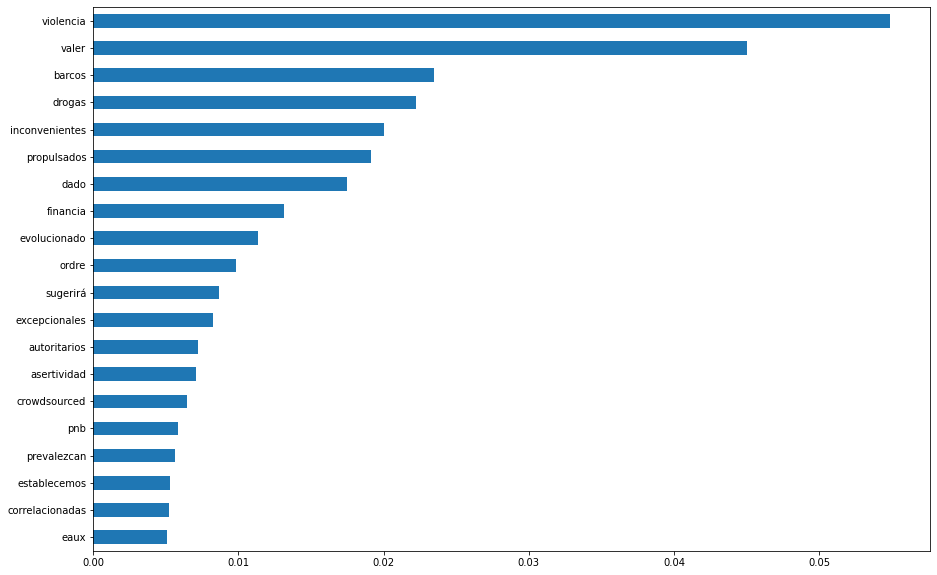

In [35]:
# Feature importance in tree models is an indicator on how relevant is a feature for taking the decision by the model
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [36]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 95.62


In [38]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["Textos_espanol"]))

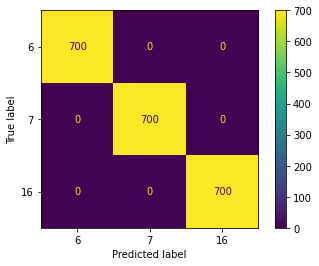

In [39]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

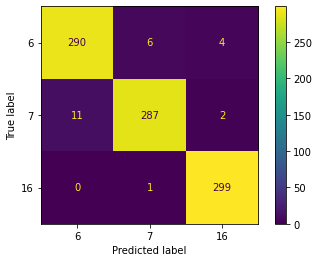

In [40]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [42]:
print("Precision:", precision_score(y_train, y_train_bow_predict, average='macro'))
print("Recall:", recall_score(y_train, y_train_bow_predict, average='macro'))
print("F1:", f1_score(y_train, y_train_bow_predict, average='macro'))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [43]:
print("Precision:", precision_score(y_test, y_test_bow_predict, average='macro'))
print("Recall:", recall_score(y_test, y_test_bow_predict, average='macro'))
print("F1:", f1_score(y_test, y_test_bow_predict, average='macro'))

Precision: 0.973324498181532
Recall: 0.9733333333333333
F1: 0.9732726515563201


## Primer acercamiento con TF-IDF

In [44]:
tfidf_model = RandomForestClassifier(random_state=3)

In [45]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<AxesSubplot:>

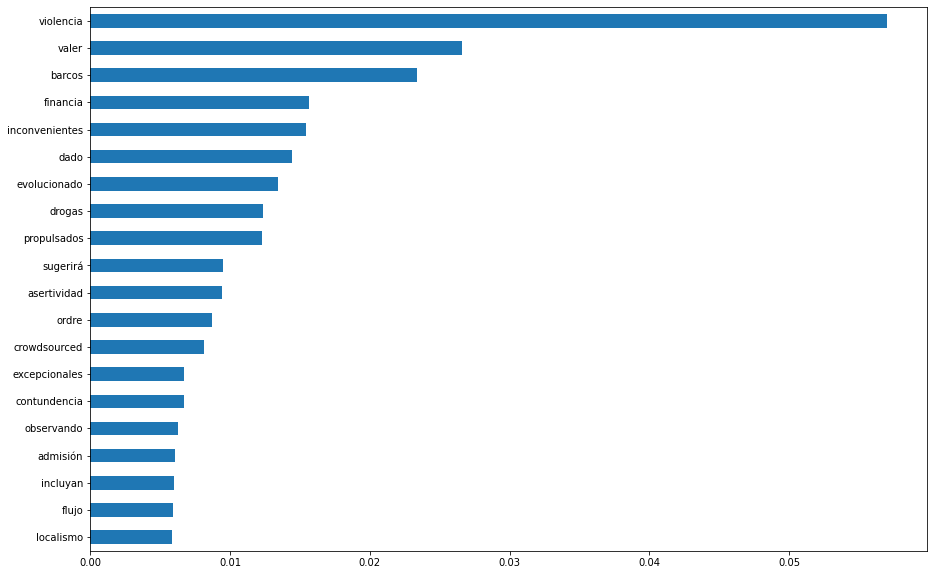

In [46]:
pd.Series(tfidf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [47]:
tfidf_estimators = tfidf_model.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 90.51


In [49]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test["Textos_espanol"]))

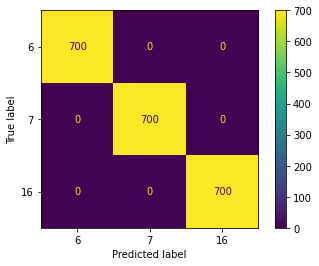

In [50]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

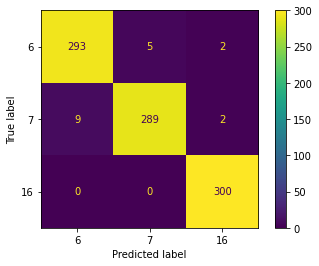

In [51]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [54]:
print("Precision:", precision_score(y_train, y_train_tfidf_predict, average='macro'))
print("Recall:", recall_score(y_train, y_train_tfidf_predict, average='macro'))
print("F1:", f1_score(y_train, y_train_tfidf_predict, average='macro'))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [55]:
print("Precision:", precision_score(y_test, y_test_tfidf_predict, average='macro'))
print("Recall:", recall_score(y_test, y_test_tfidf_predict, average='macro'))
print("F1:", f1_score(y_test, y_test_tfidf_predict, average='macro'))

Precision: 0.9800113260129194
Recall: 0.98
F1: 0.9799544611393269
